#Credit Risk Decision Engine Data Wrangling and Feature Engineering



## Kaggle Key configurations

In [5]:
import json
import os

# Replace with your actual username and key from Kaggle settings
info = {"username": "kaggleuser", "key": "kagglekey"}

# Create the .kaggle directory and save the file
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(info, f)

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

##Installing libraries and data


### Lending Club Datasets

In [6]:
!pip install -q kaggle pandas numpy matplotlib seaborn

#Obtaining the lending-club data from wordsforthewise's accounts
!kaggle datasets download -d wordsforthewise/lending-club
!unzip -q lending-club.zip


Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 99% 1.25G/1.26G [00:09<00:00, 296MB/s]
100% 1.26G/1.26G [00:09<00:00, 145MB/s]


In [8]:

#Using pandas and numpy for preprocessing data
import pandas as pd
import numpy as np

print("Loading data...")
#Taking 2007 to 2018 datasets
df = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=False)

# Defining the targets i.e. loan status for our project
print("\nUnique Loan Statuses before cleaning:")
print(df['loan_status'].value_counts())

# We only want loans that are matured/finished/known
# and ignore loans that ongoing/current
valid_statuses = ['Fully Paid', 'Charged Off', 'Default']
df_clean = df[df['loan_status'].isin(valid_statuses)].copy()

# Creating the binary target:
# 1 = Bad Loan (Default/Charged Off)
# 0 = Good Loan (Fully Paid)
df_clean['target'] = df_clean['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

print("\nFinal Dataset shape (Rows, Cols):", df_clean.shape)
print("Target Distribution (1 is Default):")
print(df_clean['target'].value_counts(normalize=True))

Loading data...

Unique Loan Statuses before cleaning:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Final Dataset shape (Rows, Cols): (1345350, 152)
Target Distribution (1 is Default):
target
0    0.80035
1    0.19965
Name: proportion, dtype: float64


### FRED datasets

In [ ]:
!pip install fredapi

from fredapi import Fred
import pandas as pd

# note use your own FRED API KEY at https://fred.stlouisfed.org/docs/api/fred/
FRED_API_KEY = 'FRED_API'
fred = Fred(api_key=FRED_API_KEY)

# Pulling the Data and selecting
# unemployment_rate, inflation_rate and feds_fund_rate
# to obtain a macroscopic context for the loan approval system
# by accurately quantifying the risk appetite of the
# loan-approval agencies in this model given the fed funds rate.
indicators = {
    'unemployment_rate': 'UNRATE',
    'inflation_rate': 'CPIAUCSL',
    'fed_funds_rate': 'FEDFUNDS'
}

econ_df = pd.DataFrame()

for name, series_id in indicators.items():
    series = fred.get_series(series_id)
    temp_df = pd.DataFrame(series, columns=[name])
    if econ_df.empty:
        econ_df = temp_df
    else:
        econ_df = econ_df.join(temp_df, how='outer')

# Prepare for Merging
# LendingClub dates are usually strings like "Dec-2015".
# We need to convert both to a "Year-Month" format for a clean join.
econ_df = econ_df.reset_index().rename(columns={'index': 'date'})
econ_df['month_year'] = econ_df['date'].dt.to_period('M')

# Processing the LendingClub DataFrame
df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'])
df_clean['month_year'] = df_clean['issue_d'].dt.to_period('M')

# Merging both the datasets
df_final = pd.merge(df_clean, econ_df[['month_year', 'unemployment_rate', 'inflation_rate', 'fed_funds_rate']],
                     on='month_year', how='left')

print("Successfully merged economic indicators!")
print(df_final[['issue_d', 'unemployment_rate', 'target']].head())

/tmp/ipython-input-3935175331.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'])


Successfully merged economic indicators!
     issue_d  unemployment_rate  target
0 2015-12-01                5.0       0
1 2015-12-01                5.0       0
2 2015-12-01                5.0       0
3 2015-12-01                5.0       0
4 2015-12-01                5.0       0


In [10]:
# List of columns that happen 'after' the loan is approved
# We do this to prevent data "leakage" which means that
# the current status of loan approval only matter at the point of the approval
# of the loan and not at the point of application for the loan
leakage_cols = [
    'funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
    'debt_settlement_flag', 'settlement_status', 'settlement_amount'
]

# Dropping the leakage causing columns and adding additional columns for
# description
drop_cols = leakage_cols + ['id', 'member_id', 'url', 'desc', 'title', 'emp_title']
df_final = df_final.drop(columns=[c for c in drop_cols if c in df_final.columns])

##Featuring Engineering

In [11]:
# Employment Stability Score
# Converting 'emp_length' (e.g., "10+ years") to numeric
df_final['emp_length_num'] = df_final['emp_length'].str.extract('(\d+)').fillna(0).astype(float)

# Credit Age
# 'earliest_cr_line' to years of credit history
df_final['earliest_cr_line'] = pd.to_datetime(df_final['earliest_cr_line'])
df_final['credit_age_years'] = (df_final['issue_d'] - df_final['earliest_cr_line']).dt.days / 365

# Utilization vs. Income
# High revolving balance relative to annual income
df_final['rev_bal_to_inc'] = df_final['revol_bal'] / (df_final['annual_inc'] + 1)

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3344559978.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_final['emp_length_num'] = df_final['emp_length'].str.extract('(\d+)').fillna(0).astype(float)
/tmp/ipython-input-3344559978.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final['earliest_cr_line'] = pd.to_datetime(df_final['earliest_cr_line'])


In [13]:
# Real DTI (Debt-to-Income Adjusted for Inflation)
# High inflation makes existing debt harder to pay back as basic costs rise.
df_final['inflation_adj_dti'] = df_final['dti'] * (1 + df_final['inflation_rate']/100)

# Employment Risk Index
# If an applicant has short job tenure during high unemployment, they are high risk.
# We use (11 - emp_length) so that shorter tenure = higher risk multiplier.
df_final['emp_unemployment_risk'] = (11 - df_final['emp_length_num']) * df_final['unemployment_rate']

# Interest Rate Gap
# The difference between the loan's interest rate and the Fed Funds Rate.
df_final['rate_premium'] = df_final['int_rate'] - df_final['fed_funds_rate']

In [14]:
# Filling missing numeric values with median
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
df_final[numeric_cols] = df_final[numeric_cols].fillna(df_final[numeric_cols].median())

# One-Hot Encoding for categorical variables
# Keeping only low-cardinality ones to avoid 'curse of dimensionality'
categorical_cols = ['home_ownership', 'verification_status', 'purpose', 'term']
df_final = pd.get_dummies(df_final, columns=categorical_cols, drop_first=True)

print(f"Feature Engineering complete. New dataset shape: {df_final.shape}")

Feature Engineering complete. New dataset shape: (1345350, 159)


## Visualization

## Feature Correlation

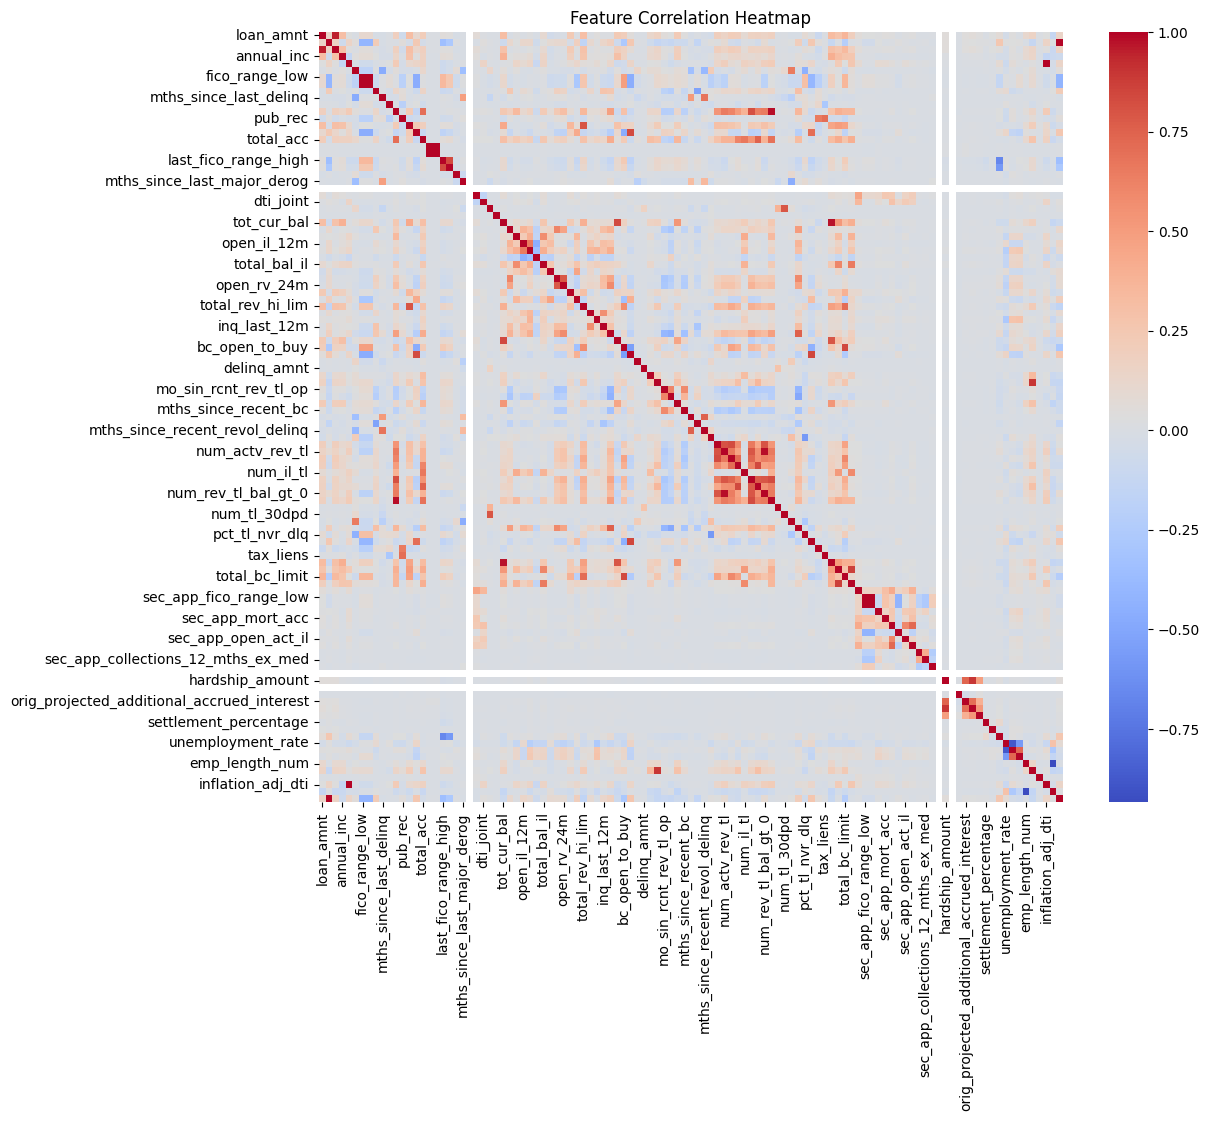

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating correlation matrix
corr = df_final[numeric_cols].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## Mutual information

Calculating feature importance (this may take a minute)...


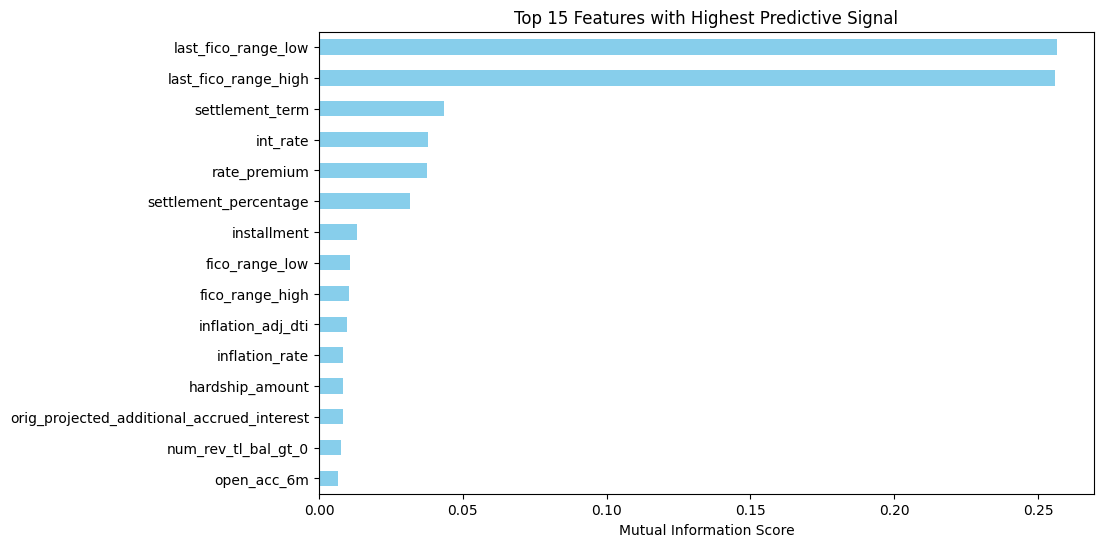

In [17]:
# Creating model_df by selecting only numeric columns and dropping the target
# We exclude 'target' because the features shouldn't include what we are trying to predict!
if 'df_final' in locals():
    model_df = df_final.select_dtypes(include=[np.number]).drop(columns=['target'], errors='ignore')
    y = df_final['target']
else:
    print("Error: Please ensure you have run the cell that creates 'df_final' first!")

# Sampling for speed (Mutual Info can be slow on millions of rows)
X_sample = model_df.sample(min(20000, len(model_df)), random_state=42)
y_sample = y.loc[X_sample.index]

# Calculating Mutual Information
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

print("Calculating feature importance (this may take a minute)...")
importances = mutual_info_classif(X_sample, y_sample)
feat_importances = pd.Series(importances, model_df.columns)

# Visualizing the Top Signal Features
plt.figure(figsize=(10, 6))
feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title("Top 15 Features with Highest Predictive Signal")
plt.xlabel("Mutual Information Score")
plt.show()